## Content
- Resampling
- Performance metrics for time series

Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

Let's use the same dataset as the one in lecture: **Mobilplus sales forecasting usecase**

We will look into this time series data in depth during the lecture. For now, we're just using this

In [2]:
mobile_sales = pd.read_excel('./mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [3]:
# set index as date
mobile_sales.set_index('DATE', inplace=True)

mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0




## Resampling

Looking at the datatime column, pandas can figure out that our data is indexed monthly.

> **Q. What if instead of forecasting for a couple months, the client wants us to forecast the data for the next say, 3 years?**

This is where the concept of **resampling** comes in.

Here, it makes sense to resample the data into a year.

This means, that instead of having monthly data, we resample the dataset to obtain yearly data.

<br>

#### Q. How can we obtain yearly sales data from monthly data?
We can convert our monthly data to yearly data by simply adding the data for all 12 months in a year, and assigning that to a new variable, that represents that particular year.

We do this by using the `resample()` method of pandas. 

Since we need to resample by year, we pass `'Y'` in the resample method.


![picture](https://drive.google.com/uc?export=view&id=1ced-VScgLuErLA860uH1u8ihoNPk1nkx)


<br>

**NOTE:** 
- When we resample up to a year from monthly data, this is called **upsampling**.

- This is very easy as we can simply take the sum of all the data points in a bucket, to obtain the upsampled data.


In [9]:
mobile_sales.resample('Y').sum().head()

,Sales
DATE,
2001-12-31,92119.0
2002-12-31,72070.0
2003-12-31,91843.0
2004-12-31,104200.0
2005-12-31,100343.0


Notice that here, instead of monthly data, we get one data point for each year, with the date set as 31st December for each year.


Lets plot this yearly data, to see how it looks.

<AxesSubplot:xlabel='DATE'>

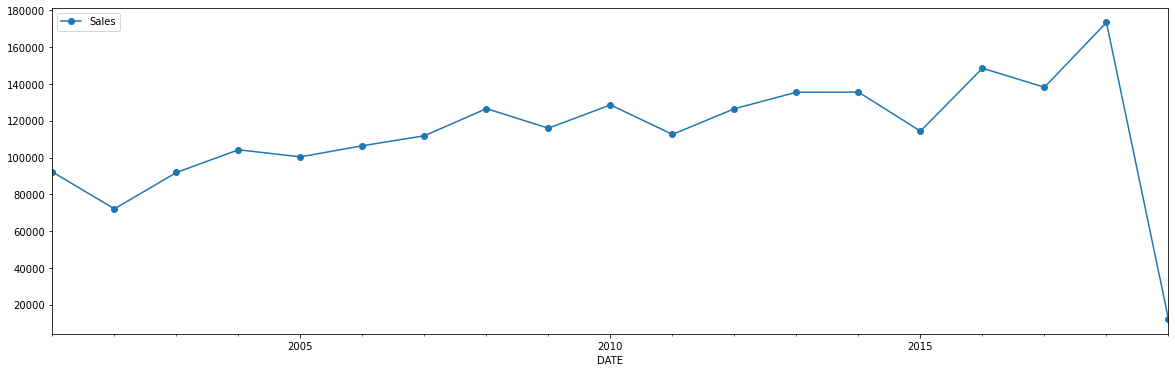

In [10]:
mobile_sales.resample('Y').sum().plot(style='-o')

> **Q. So What exactly is resampling?**

Since we are looking at time series data, there may arise situations where we wish to manipulate the time frame of our data (seconds, days, months, years).

Resampling means sampling the existing data according to our requirement, by either upsampling or downsampling.

<br>

> **Q. Why do we need to perform resampling?**

In practice, there are 2 main reasons why using resample.
1. To inspect how data behaves differently under different resolutions or frequency.
2. To join datasets/tables with different resolutions.


<br>

> **Q. Are there any pre requisites to resampling?**

There are 2 prerequisites to carry out resampling:

1. The Datetime column must be in “datetime” or “timestamp” data type.
2. The Datetime column must be the index. 
 - Alternatively, you can use the ‘on’ parameter to define the column to carry out resampling (not supported in upsampling).

As you can see, both these conditions are already met in our dataset.

 <br>

> **Q. Why did we use `sum()`, is there any other way of doing resampling?**

During resampling, we used the `sum()` method, because it makes logical sense to add up the monthly sales in order to obtain the yearly sale values.

Yes, there are other ways of resampling.

Instead of `sum()`, we could've theoretically used other methods such as `max(), min(), or mean()`. 

But in the context of upsampling in time series, that does not make sense.

We saw how we can upsample our data, by taking sum. 

> **Q. Can we downsample data as well?**

Yes.

Let's try downsampling by finding data indexed by **day**.

For doing so, we will use `'D'` inside the `resample()` method.

In [11]:
mobile_sales.resample('D').sum().head()

,Sales
DATE,
2001-01-01,6519.0
2001-01-02,0.0
2001-01-03,0.0
2001-01-04,0.0
2001-01-05,0.0


Uh-oh, there seems to be a problem!

<br>

> **Q. What went wrong in downsampling?**

We are trying to find out daily sales data from the given monthly sales data.

And we used `sum()` method as the aggregate function for resampling.

So, technically, nothing went wrong 
- We were able to successfully obtain daily sales data such that 
- the sum of daily mobile sales in a month is in fact equal to the monthly sale values.

We are essentially trying to fill in the values that we don't have.

<br>

> **Q. How do we go about solving this problem?**

Intuitively, we can think that if the number of mobiles sold in a month, say January is X, then the number of mobiles sold each day is $X / 31$, where 31 is the number of days in the month of January.

$\frac{X}{31} + \frac{X}{31} + ...31 \ times = X$

This will give us the best estimate for daily data

<br>

So we use **forward fill** here, which replaces all values of days in January with the monthly value of January, and then we can simply divide this with the number of months in January i.e. 31

<br>

> **Q. So essentially we're taking the average of values, why not just change the aggregate function to `mean()`?**


This makes logical sense, Let's try doing this.

In [12]:
mobile_sales.resample('D').mean().head()

,Sales
DATE,
2001-01-01,6519.0
2001-01-02,NaN
2001-01-03,NaN
2001-01-04,NaN
2001-01-05,NaN


As you can see, using `mean()` as the aggregate function just ends up assigning the monthly value to the 1st of each month, and assigns all other days' sales value as **NaN**.

In [13]:
temp = mobile_sales.resample('D').mean().fillna(method='ffill')
temp['year-month'] = temp.index.year * 100 + temp.index.month
temp['base'] = temp.groupby('year-month')['Sales'].transform('count')
temp['Sales'] = temp['Sales'] / temp['base']
temp.head()

,Sales,year-month,base
DATE,,,
2001-01-01,210.290323,200101,31
2001-01-02,210.290323,200101,31
2001-01-03,210.290323,200101,31
2001-01-04,210.290323,200101,31
2001-01-05,210.290323,200101,31


> **Q. Why bother performing downsampling?**

Though, this is not adding any more information, there may arise a situation where we need to resample just because we need to **mix up** another signal which is in daily level.

So, in order to mix the two signals, we need to first downsample our given data, which is in monthly level.

![picture](https://drive.google.com/uc?export=view&id=1-sZGuTrCa4WMPzug1rA2yg4scLERYLhD)

<br>



## Performance Metrics in a time series

Before getting into performance metrics, Let's do all the data processing we learnt about in the lecture
- Setting index as date
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the resultant time series

<AxesSubplot:xlabel='DATE'>

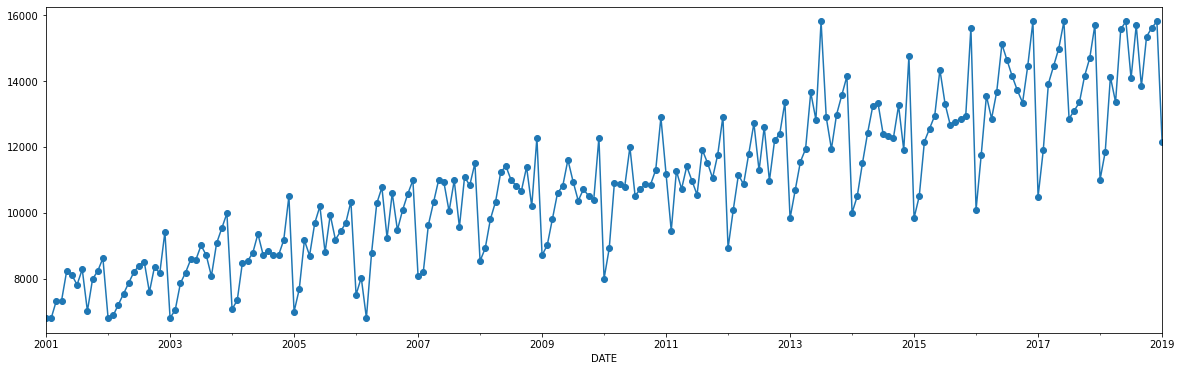

In [14]:
# index already set as date column

# linear interpolation 
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

In [15]:
# Splitting our data in train and test sets
# Will be covered in Lecture 2 of time series

train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()



Lets take a look at a few performance metrics that help us evaluate how good or bad our forecasts are in a time series, by implementing them over a simple **Naive Model** of forecasting.

You have already learnt all of these metrics.

Let's see them getting used in context  of time series.

In [16]:
# Naive forecast: Forecasting the last value of the series forever

test_x['pred'] = train_x['Sales'][-1]

### 1. Mean Error

ME is a measure of the average of the difference between each Actual and predicted value.

The formula for Mean Absolute Error is as follows:


<center><h3> $ME = \frac{1}{N} \sum_{i=1}^{N} y_{i}-\hat{y}_{i}$</h3></center>

In the above equation, 

$\hat{y}$ -> predicted value and  <br>
y -> actual value. <br>
N -> total no. of observations


AIM: to get a ME value near 0

In [17]:
mean_error = np.sum(test_x['Sales'] - test_x['pred']) / len(test_x)

print(mean_error)

3434.2333333333336



**Note:** This is the same as **residual** we looked in the lecture.

<br>

#### Q. What do we want our residual to look like?
- Ideally we would like a value near 0, this way we know that even though sometimes we overpredict or underpredict, on an average, we're getting negligible error.

- Expected to be **normal** distribution.
- Have lower standard deviation.

<br>

#### Q. What is the problem with ME?
The problem is that, positive and negative errors cancel each other's effect. 

So we can get a very good ME score, but the model would actually be performing very bad.

### 2. Mean Absolute Error (MAE)

So to overcome this cancellation of negative and positive errors we use **Mean Absolute error** which takes the **absolute error of the terms** 

Mean Absolute Error is a measure of the average of the absolute difference between each Actual and predicted value.  

The formula for Mean Absolute Error is as follows:


<center><h3> $MAE = \frac{1}{N} \sum_{i=1}^{N}\left | y_{i}-\hat{y}_{i} \right |$</h3></center>

In [18]:
from sklearn.metrics import mean_absolute_error as mae

print(mae(test_x['Sales'], test_x['pred']))

3434.2333333333336



AIM: to get a minimum MAE value

This will always be a positive value.

### 3. Mean Square Error (MSE)
- Takes the average of the square of the difference between the original values and the predicted values.
- As we take square of the error, the effect of **larger errors** (sometimes outliers) become **more pronounced** then smaller error as a result of which model will be **penalized more for bad predictions**.
- Before applying MSE, we must **eliminate all nulls/infinites** from the input.
- **Not robust** to outliers
- **Range (0, + infinity]**

Formula to calculate MSE is as follows:-

<center><h3> $MSE = \frac{1}{N}\sum_{i=1}^{N} (y_{i} - \hat{y}_{i})^2$ </h3></center>

AIM: To get minimum MSE value

In [19]:
# Importing in-built function from sklearn.metrics
from sklearn.metrics import mean_squared_error

print("MSE: ", mean_squared_error(test_x['Sales'], test_x['pred']))

MSE:  13667844.726666668


The problem with MSE is that, it becomes **exponentially larger**.

It is not in the scale of unit of time series, it is in $(unit)^2$.
- Our time series is in range of 6000 to 16,000
- MSE is 1,36,67,844.727

Hence we look at RMSE.

### 4. Root Mean Square Error (RMSE)
Root mean Squared Error is defined as the square root of the average of the squared difference between the predicted values and actual values.

It is essentially the square root of MSE

<center><h3> $RMSE = \sqrt{\frac{\sum_{i=1}^{N} (y_{i} - \hat{y}_{i})^2}{N}}$</h3></center>

In [20]:
print("RMSE: ", np.sqrt(mean_squared_error(test_x['Sales'], test_x['pred'])))

RMSE:  3697.0048318424833


- Notice that the RMSE is **greater than MAE**. 
- The reason is RMSE is squaring the difference between the predictions and the ground truth, any significant difference is made more substantial when it is being squared. 
- **RMSE is more sensitive to outliers.**

AIM: To get a minimum RMSE value

### 5. Mean Absolute Percentage Error (MAPE)

To get the percentage error values we use **Mean Absolute Percentage Error** (MAPE), which is obtained by dividing the absolute error with actual value and finding the mean of these terms.

Formula:
 

<center><h3> $MAPE = \frac{1}{N} \sum_{i=1}^{N}\left | \frac{y_{i}-\hat{y}_{i}}{y_i} \right |$</h3></center>

In [21]:
from sklearn.metrics import mean_absolute_percentage_error as mape

print(mape(test_x['Sales'], test_x['pred']))

0.2304265941596256


So, there is a 23% error in these forecasts. 

#### Q. What is advantage of MAPE?
In other metrics we've seen, we would need to look at that metric's value for all the models we're trying, to understand how each model performs. 

They provide relative comparison of models.

With MAPE, we get an percentage of correct forecasts. We don't need to to look at MAPE values of other models to get an idea of how our model is performing.

<br>

#### Q. What if y = 0 for a point?
That would be a problem as MAPE would become **undefined** for the entire data that way.

Therefore, one would have to use another metric for the points where real value is 0. This is just inconvenient.


**NOTE:**
- It isn't always easy to select one single metric for performance evaluation.
- Sometimes, based on the domain, you would need to try out a bunch of different metrics, to check the performance.

So, we can see that the Naive Method of forecasting is not a very good performing method.

In the next lecture, we will look at other models of forecasting a time series.